# Filter sequences with known multimeric state

Took the proteins from https://www.ebi.ac.uk/pdbe/pisa/ and their multimeric state. Found a set of non-redundant proteins with known oligomeric state

Might still need to think about cases where free energy is undefined. Also when the free energy is pisa but the pisa structure is not a monomer

In [2]:
# imports 
from Bio import SeqIO
import pandas as pd
import seaborn as sns 
from collections import Counter
import re
import json 
import matplotlib.pyplot as plt
import numpy as np

Amino acid sequences of proteins in the pdb

In [3]:
# read in the sequences 
fasta_dict = SeqIO.to_dict(SeqIO.parse("pdb_seqres.txt", "fasta")) # fasta of all sequences in the pdb as of 18/11/2024
fasta_keys = list(fasta_dict.keys())

PISA multimer predictions of proteins in the pdb

In [4]:
# read in the sequences in pisa 
pisa = pd.read_csv('dbsres.dat', delim_whitespace=True, skiprows=1)
pisa = pisa[['No.', 'sq.A', 'sq.A.1', 'kcal/mol']].reset_index().drop('level_0', axis=1)
pisa.columns = ['PDB_id', 'mmSize', 'Sym. num.', 'ASA sq.A', 'BSA sq.A', 'Delta G kcal/mol' ] 

In [5]:
pisa

,PDB_id,mmSize,Sym. num.,ASA sq.A,BSA sq.A,Delta G kcal/mol
0,6zlz,360,60,4118668.5,4287972.1,15688.2
1,1sva,360,60,4585341.7,13915.4,NaN
2,1sie,360,60,4145159.6,6720.1,NaN
3,1sid,360,60,4174291.9,6455.0,NaN
4,2qa0,60,60,790256.6,994224.3,6199.0
...,...,...,...,...,...,...
118781,3zm5,1,1,20693.7,0.0,0.0
118782,3zm4,1,1,15246.0,0.0,0.0
118783,3zly,1,1,15181.2,0.0,0.0
118784,3zlx,1,1,15126.3,0.0,0.0


Plot the distribution of proteins by their oligomeric state

<ipython-input-5-af8f90f8c04c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pisa['mmSize'])


(0.0, 20.0)

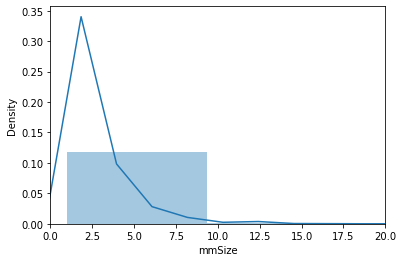

In [5]:
homomer_counts = pd.DataFrame.from_dict(Counter(pisa['mmSize']), orient='index').sort_index()
sns.distplot(pisa['mmSize'])
plt.xlim((0,20)) 

Can see that not much occurs with multiplicity greater than 12 - removed these sequences 

In [6]:
pisa_12less = pisa[pisa['mmSize'] <= 12].reset_index() # remove anything with multiplicity greater than 12 


There are some inconsistencies. For example 6j1u is a trimer in the pdb. Maybe go back and make comparisons between these and the ser uploaded ones for these incorrect predictions 

In [7]:
monomers = pisa_12less[pisa_12less['mmSize'] != 1]
monomers[monomers['Delta G kcal/mol'] == 0]

,index,PDB_id,mmSize,Sym. num.,ASA sq.A,BSA sq.A,Delta G kcal/mol
60442,61316,2osu,4,4,48226.3,6086.0,0.0
60443,61317,1pi5,2,2,28094.9,3233.1,0.0
60444,61318,4dt5,2,2,11607.6,2720.9,0.0
60445,61319,2gn3,2,2,17972.9,2608.0,0.0
60446,61320,4oci,2,2,14094.0,3481.3,0.0
...,...,...,...,...,...,...,...
60553,61427,4eh1,2,1,20939.4,6240.7,0.0
60555,61429,6gtt,2,2,28538.5,4045.4,0.0
60556,61430,6n0v,4,4,67647.8,13741.3,0.0
60557,61431,6dm3,2,2,12396.1,1339.9,0.0


# Deal with 'obsolete entries' 

Some of the proteins in PISA have since been removed or moved to a different pdb id. Update or removed these sequences. 

In [8]:
# read in obsolete entries so they can be mapped 
with open('all_removed_entries.json', 'r') as file:
    obsolete = json.load(file)  # data is now a dictionary
    
# read in obsolete entries     
obsolete_keys = [item.lower() for item in obsolete]
obsolete = dict(zip(obsolete_keys, obsolete.values()))

# get the obsolete sequences in pisa 
pisa_obsolete = set(pisa['PDB_id']).intersection(set(obsolete_keys))

In [9]:
removed = [] # sequences removed from the pdb 
replacements = [] 
originals = [] 

for i in list(pisa_obsolete): 
    details = obsolete.get(i)
     
      
    if 'superseded_by' in details.keys(): 
        replacements.append(details.get('superseded_by')[0])
        originals.append(i)
    
    else: 
        print(details.get('details') + '\n')
        removed.append(i) 
        

Entry obsoleted in response to US Office of Research Integrity Notice 2018-07782

THIS ENTRY WAS WITHDRAWN AT THE REQUEST OF THE AUTHOR

The entry is obsoleted due to paper retraction.

The entry is obsoleted due to paper retraction

Obsoletion upon authors request, no known superseding entry

THE ENTRY IS OBSOLETED PER AUTHORS REQUEST SINCE IT IS DUPLICATE OF 5WH8

The entry is obsoleted due to paper retraction

Released prematurely

The author states that the structure is incorrect and that re-refine entry will be available later.

THIS ENTRY IS FROM THE WRONG SAMPLE AND WAS WITHDRAWN AT THE REQUEST OF THE AUTHOR.

Based on a recent review of the data, it appears the wrong structure factors were submitted with the coordinates.   The overall structure of the protein is correct, however the active site ligand was misinterpreted.

Entry obsoleted in response to US Office of Research Integrity Notice 2018-07782

PDB ENTRY 4M7N HAS BEEN MADE OBSOLETE BECAUSE IT IS IDENTICAL TO PDB ENTRY 4

In [10]:
#read in the replacement entries 
obsolete_seqs = SeqIO.to_dict(SeqIO.parse("obsolete_replacements.faa", "fasta"))
new_keys = [re.split('\|', i) for i in list(obsolete_seqs.keys())]
new_keys = [n[0] if len(n)==3 else n[-1][4:] for n in new_keys]
obsolete_seqs = dict(zip(new_keys, list(obsolete_seqs.values())))

In [11]:
# add the missing sequences to the dictionary 
for idx, o in enumerate(originals): 
    
    fasta_dict[o] = obsolete_seqs.get(str.lower(replacements[idx]))
    
# manually add entry that gets lost (these got consolidated in a later versions)
fasta_dict['6iqb'] = obsolete_seqs.get(str.lower('7c2d'))
fasta_dict['6iq9'] = obsolete_seqs.get(str.lower('7c2d'))
fasta_dict['6iq7'] = obsolete_seqs.get(str.lower('7c23'))
fasta_dict['6iq8'] = obsolete_seqs.get(str.lower('7c29'))
fasta_dict['4i1x'] = obsolete_seqs.get(str.lower('6ahi'))
fasta_dict['6khw'] = obsolete_seqs.get(str.lower('7y6m'))
fasta_dict['7c0a'] = obsolete_seqs.get(str.lower('7vjn'))
fasta_dict['4zrh'] = obsolete_seqs.get('5v3p')
fasta_dict['4s19'] = obsolete_seqs.get('5yar')
fasta_dict['4s06'] = obsolete_seqs.get('5z05')
fasta_dict['3nyh'] = obsolete_seqs.get('7dlq')
fasta_dict['3q9k'] = obsolete_seqs.get('7dn6')
fasta_dict['3ql6'] = obsolete_seqs.get('7dn7')


# Filter to find the entries with more than one sequence listed 

Even though I selected 'homomer' in pisa, some pdb entries have more than one seqence listed. Do not consider these entries

In [170]:
# Assuming fasta_keys is a list of strings and 'PDB_id' are substrings of interest

# Create a mapping (dictionary) of PDB IDs to their corresponding keys for faster access
from collections import defaultdict

fasta_keys = list(fasta_dict.keys())

pdb_map = defaultdict(list)
for key in fasta_keys:
    # Extract unique PDB identifiers from keys, modify extraction as per your exact pattern requirements
    pdb_id = re.split('_', key)[0] 
    pdb_map[pdb_id].append(key)

multi_sequence = []
single_sequence = [] 
keep_seqs = [] 

for index, row in pisa_12less.iterrows():
    # Direct lookup in dictionary instead of list comprehension
    seqs = pdb_map.get(row['PDB_id'])
    
    # Generate set of unique sequences
    seq_list = {str(fasta_dict[key].seq) for key in seqs}

    # Check for heteromer condition
    if len(seq_list) > 1:
        multi_sequence.append(row['PDB_id'])
    else: 
        single_sequence.append(row['PDB_id'])
        keep_seqs.append(seqs[0])

## write the resulting sequences to a fasta file 

In [167]:
fasta_out = [fasta_dict.get(k) for k in keep_seqs] 
for idx, f in enumerate(fasta_out): 
    f.id = single_sequence[idx] 
    f.description = '' 
             

# Open the output file for writing
with open("filtered_seqs.faa", "w") as output_handle:
    for record in fasta_out:
        # Write the header line
        output_handle.write(f">{record.id}\n")
        
        # Write the full sequence on one line
        output_handle.write(str(record.seq) + "\n")

Sequences were then clustered with mmseqs easy-cluster 

`mmseqs easy-cluster filtered_seqs.faa  cluster_pisa_minseqid0.9_c0.8  ./tmpppp --min-seq-id 0.9 -c 0.8 --cov-mode 1`

This was repeated using different values of `--min-seq-id` 

# Determine a set of non-redundant sequences with known state

In [7]:
seqid = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0] 
num_clusters = [] 
mmsize_dominance_list = []
mmsize_dominance_weighted_list = [] 
cluster_size_list = [] 

symnum_dominance_list = [] 
seqid_list = [] 

tab_stack_counts_list = [] 

mmsize_dict = dict(zip(pisa_12less['PDB_id'], pisa_12less['mmSize'])) 
symnum_dict = dict(zip(pisa_12less['PDB_id'], pisa_12less['Sym. num.'])) 

for c in seqid: 
    
    print(c)
    
    tab_file = 'cluster_pisa_minseqid' + str(c) + '_c0.8_cluster.tsv' 
    tab = pd.read_csv(tab_file, sep = '\t', header=None)
    tab['mmsize'] = [mmsize_dict.get(t) for t in tab[1]]
    tab['symnum'] = [symnum_dict.get(t) for t in tab[1]]
    num_clusters.append(len(list(set(tab[0]))))
    
    tab_stack = tab.groupby(0).agg({ 1: list,'mmsize': list,'symnum': list }).reset_index() 
    tab_stack['mmsize dominance'] = [max(Counter(t).values())/len(t) for t in tab_stack['mmsize']]  #TODO - maybe this dominance score needs to be normalised by the number of sequences in the cluster
    mmsize_dominance_list.extend(tab_stack['mmsize dominance']) 
    tab_stack['symnum dominance'] = [max(Counter(t).values())/len(t) for t in tab_stack['symnum']]  #TODO - maybe this purity score needs to be normalised by the number of sequences in the cluster
    symnum_dominance_list.extend(tab_stack['mmsize dominance']) 
    
    tab_stack['mmsize dominance size-weighted'] = [(max(Counter(t).values())/len(t))/(1/(1+(1/len(t)))) for t in tab_stack['mmsize']]  #TODO - maybe this dominance score needs to be normalised by the number of sequences in the cluster
    mmsize_dominance_weighted_list.extend(tab_stack['mmsize dominance size-weighted']) 
    
    tab_stack['seqid'] = c
    seqid_list.extend(tab_stack['seqid'])
    cluster_size_list.extend([len(t) for t in tab_stack[1]]) 
    
    tab_stack_counts = [Counter(t) for t in tab_stack['mmsize']]
    tab_stack_counts = [max(cc, key=cc.get) for cc in tab_stack_counts]
    tab_stack_counts_list.append(tab_stack_counts)


0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.95
0.99
1.0


In [21]:
# need to consider that high dominance is better for big clusters. Need to incorporate this consideration into the calculation 
# Big clusters should be priortised over small clusters (small with a dominance of 1 doesn't really mean anything)

In [32]:
cluster_size_df = pd.DataFrame({'seqid': seqid_list, 'cluster size': cluster_size_list, 'dominance': mmsize_dominance_list}) 
num_clusters_df = pd.DataFrame({'seqid': seqid, 'num_clusters': num_clusters})

### Plot the number of clusters

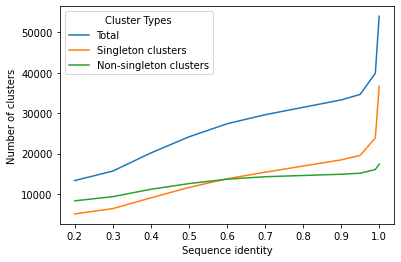

In [24]:
singleton_df = pd.DataFrame.from_dict(Counter(cluster_size_df[cluster_size_df['cluster size'] == 1]['seqid']), orient = 'index').reset_index()
nonsingleton_df = pd.DataFrame.from_dict(Counter(cluster_size_df[cluster_size_df['cluster size'] != 1]['seqid']), orient = 'index').reset_index()

# Create the plot with labels
sns.lineplot(data=num_clusters_df, x='seqid', y='num_clusters', label='Total')
sns.lineplot(data=singleton_df, x='index', y=0, label='Singleton clusters')
sns.lineplot(data=nonsingleton_df, x='index', y=0, label='Non-singleton clusters')

# Add a title and legend
plt.legend(title='Cluster Types')
plt.xlabel('Sequence identity')
plt.ylabel('Number of clusters')

# Show the plot
plt.show()

### Plot of cluster size and dominance of the non-singleton clusters

Text(0, 0.5, 'Mean Berger-Parker index')

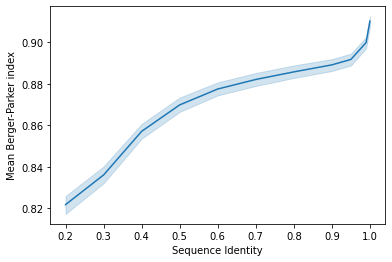

In [35]:
df = cluster_size_df[cluster_size_df['cluster size'] != 1]
#df['dominance'] = mmsize_dominance_list
sns.lineplot(data=df, x = 'seqid', y='dominance') # average dominance of non-singleton clusters 
plt.xlabel('Sequence Identity')
plt.ylabel('Mean Berger-Parker index')

<AxesSubplot:xlabel='seqid', ylabel='cluster size'>

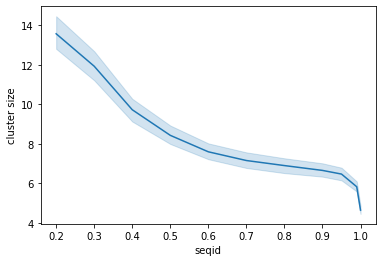

In [82]:
sns.lineplot(data = df, x = 'seqid', y='cluster size')

From this output - fold the non-singleton proteins first and the proteins with a sequence identity of 0.6 

# Select sequences for further analysis

In [149]:
clusters = pd.read_csv('cluster_pisa_minseqid0.6_c0.8_cluster.tsv', sep = '\t', header = None)
clusters = sequences.groupby(0).agg({1:list}) 

clusters['cluster size'] = [len(i) for i in clusters[1]] 
clusters[clusters['cluster size'] > 1]

In [185]:
fasta_search = SeqIO.to_dict(SeqIO.parse("cluster_pisa_minseqid0.6_c0.8_rep_seq.fasta", "fasta"))

nonsingletons = [fasta_search.get(c) for c in  clusters[clusters['cluster size'] > 1].index]

# Open the output file for writing
with open("nonsingleton_cluster_pisa_minseqid0.6_c0.8_rep_seq.fasta", "w") as output_handle:
    for record in nonsingletons:
        # Write the header line
        output_handle.write(f">{record.id}\n")
        
        # Write the full sequence on one line
        output_handle.write(str(record.seq) + "\n")